In [ ]:
# Check GPU
!nvidia-smi

Fri Jul 18 16:01:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Install TensorFlow (should already be installed in Colab)
!pip install -q tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Chest Model

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Set paths
base_dir = '/content/drive/MyDrive/chest'
img_size = (224, 224)
batch_size = 32

# Augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 6326 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Found 771 images belonging to 4 classes.


In [ ]:
# Since val set is very small, so we will be moving some images from train set to val set

import os
import shutil
from sklearn.model_selection import train_test_split

# Paths (adjust if needed)
original_train_dir = '/content/drive/MyDrive/chest/train'
val_dir = '/content/drive/MyDrive/chest/val'
val_split = 0.15  # 15% for validation

# Create val directory if it doesn't exist
os.makedirs(val_dir, exist_ok=True)

# For each class folder (e.g., COVID19, PNEUMONIA)
for class_name in os.listdir(original_train_dir):
    class_train_path = os.path.join(original_train_dir, class_name)
    class_val_path = os.path.join(val_dir, class_name)
    os.makedirs(class_val_path, exist_ok=True)

    images = os.listdir(class_train_path)
    train_imgs, val_imgs = train_test_split(images, test_size=val_split, random_state=42)

    for img_name in val_imgs:
        src_path = os.path.join(class_train_path, img_name)
        dst_path = os.path.join(class_val_path, img_name)
        shutil.move(src_path, dst_path)

    print(f"Moved {len(val_imgs)} images from {class_name} to validation set.")

Moved 202 images from NORMAL to validation set.
Moved 582 images from PNEUMONIA to validation set.
Moved 98 images from TURBERCULOSIS to validation set.
Moved 69 images from COVID19 to validation set.


In [ ]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5375 images belonging to 4 classes.
Found 988 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load EfficientNetB0 base
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)  # 4 disease classes

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Save best model
checkpoint_path = "/content/chest_model.keras"

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, save_best_only=True)
]

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 3435s 20s/step - accuracy: 0.3507 - loss: 1.4285 - val_accuracy: 0.6538 - val_loss: 0.8453
Epoch 2/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 148s 880ms/step - accuracy: 0.6843 - loss: 0.7739 - val_accuracy: 0.7530 - val_loss: 0.6263
Epoch 3/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 140s 836ms/step - accuracy: 0.7706 - loss: 0.5922 - val_accuracy: 0.8138 - val_loss: 0.5117
Epoch 4/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 139s 827ms/step - accuracy: 0.8222 - loss: 0.4858 - val_accuracy: 0.8401 - val_loss: 0.4399
Epoch 5/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 138s 823ms/step - accuracy: 0.8481 - loss: 0.4163 - val_accuracy: 0.8623 - val_loss: 0.3932
Epoch 6/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 142s 842ms/step - accuracy: 0.8665 - loss: 0.3650 - val_accuracy: 0.8725 - val_loss: 0.3614
Epoch 7/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 141s 838ms/step - accuracy: 0.8820 - loss: 0.3397 - val_accuracy: 0.8775 - val_loss: 0.3367
Epoch 8/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 140s 835ms/step - accuracy: 0.8832 - 

In [ ]:
# Path to your drive
model_save_path = '/content/drive/MyDrive/chest_model.keras'

# Save the model
model.save(model_save_path)

In [ ]:
# Evaluate on unseen test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n🧠 Test Accuracy: {test_acc*100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 382s 16s/step - accuracy: 0.7865 - loss: 0.5094

🧠 Test Accuracy: 84.05%


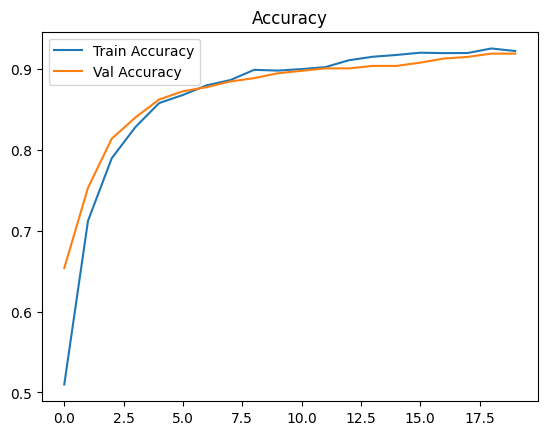

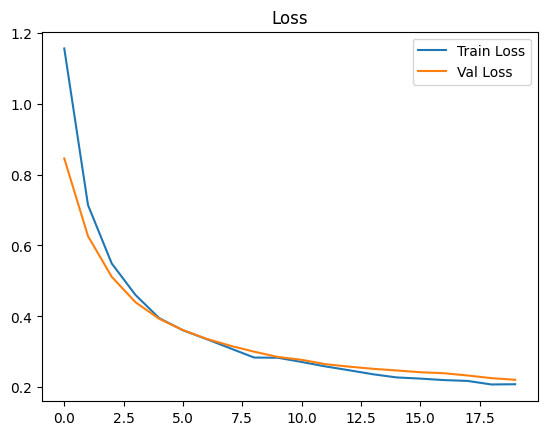

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np

# Predict probabilities
pred_probs = model.predict(test_generator)
# Get class indices
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 652ms/step


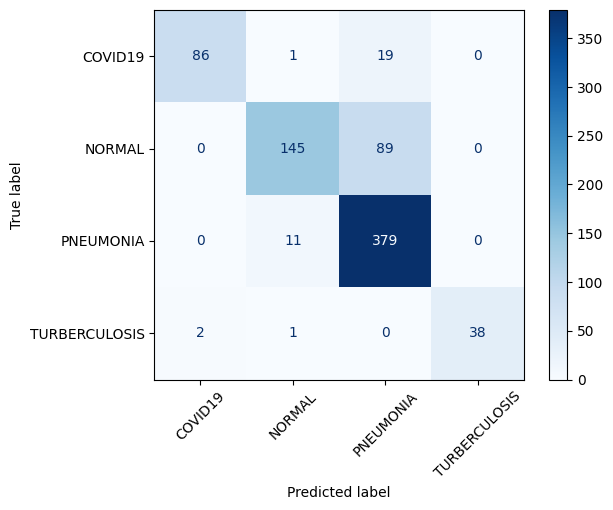

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_labels))

               precision    recall  f1-score   support

      COVID19       0.98      0.81      0.89       106
       NORMAL       0.92      0.62      0.74       234
    PNEUMONIA       0.78      0.97      0.86       390
TURBERCULOSIS       1.00      0.93      0.96        41

     accuracy                           0.84       771
    macro avg       0.92      0.83      0.86       771
 weighted avg       0.86      0.84      0.83       771



In [ ]:
# Compute per-class accuracy manually
correct_per_class = np.zeros(len(class_labels))
total_per_class = np.zeros(len(class_labels))

for i in range(len(y_true)):
    total_per_class[y_true[i]] += 1
    if y_true[i] == y_pred[i]:
        correct_per_class[y_true[i]] += 1

for idx, class_name in enumerate(class_labels):
    acc = correct_per_class[idx] / total_per_class[idx]
    print(f"{class_name}: {acc*100:.2f}% accuracy")

COVID19: 81.13% accuracy
NORMAL: 61.97% accuracy
PNEUMONIA: 97.18% accuracy
TURBERCULOSIS: 92.68% accuracy
